In [17]:
import torch as th
import numpy as np
import pandas as pd
import dgl

In [18]:
# import json
# raw_f = json.load(open('./processed_data/LastFM_node_feature.json'))
# # 7624 nodes, 7842 features
# feat = th.zeros([7624, 7842])

# for i in raw_f.keys():
#   feat[int(i), th.tensor(raw_f[i], dtype=th.long)] = 1

# np.savetxt("LastFM_node_feature.csv", feat.numpy(), delimiter=",", fmt='%d')

In [19]:
# %%
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--dataname', type=str, default='LastFM')
parser.add_argument('--gpu', type=int, default=2)
parser.add_argument('--debias_method', type=str, default='uge-r', choices=['uge-r', 'none', 'random'], help='debiasing method to apply')
parser.add_argument('--debias_attr', type=int, default=1, help='idx of sensitive attribute to be debiased')
parser.add_argument('--num_sens', type=int, default=3, help='# of sensitive attr to make')
parser.add_argument('--reg_weight', type=float, default=0.2, help='weight for the regularization based debiasing term')  

parser.add_argument('--epochs', type=int, default=200, help='Number of training periods.')
parser.add_argument('--lr', type=float, default=0.001, help='Learning rate.')
parser.add_argument('--wd', type=float, default=1e-5, help='Weight decay.')
parser.add_argument('--temp', type=float, default=1.0, help='Temperature.')

parser.add_argument("--hid_dim", type=int, default=256, help='Hidden layer dim.')
parser.add_argument("--out_dim", type=int, default=7, help='Output layer dim.')

parser.add_argument("--num_layers", type=int, default=2, help='Number of GNN layers.')
parser.add_argument("--seed", type=int, default=100, help='seed')
parser.add_argument('--der1', type=float, default=0.2, help='Drop edge ratio of the 1st augmentation.')

parser.add_argument('--sim_diff_ratio', type=float, default=5, help='Drop feature ratio of the 2nd augmentation.')
parser.add_argument('--enable_heuristic', type=str, default='Y', help='Drop feature ratio of the 2nd augmentation.')


args = parser.parse_args("")

if args.gpu != -1 and th.cuda.is_available():
    args.device = 'cuda:{}'.format(args.gpu)
else:
    args.device = 'cpu'

np.random.seed(args.seed)
th.manual_seed(args.seed)

if args.device != 'cpu':
    th.cuda.manual_seed(args.seed)

In [20]:
adj = pd.read_csv('./cora_sll_adj_lock.csv', engine='c', header=None)
feat = pd.read_csv('./cora_sll_feat.csv', engine='c', header=None)
g0 = pd.read_csv('./cora_sll_protected.csv', engine='c', header=None)
label = pd.read_csv('./cora_sll_label.csv', engine='c', header=None)

adj = th.tensor(adj.to_numpy())
feat = th.tensor(feat.to_numpy())
g0 = th.tensor(g0.to_numpy())
label = th.tensor(label.to_numpy())

edges = adj.to_sparse().indices().int()
graph = dgl.graph((edges[0], edges[1]))
graph.ndata['feat'] = feat.float()
graph.ndata['label'] = label.squeeze().float()
graph.ndata['g0'] = g0.squeeze().float()
graph = graph.add_self_loop()
graph

Graph(num_nodes=2708, num_edges=15876,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32), 'g0': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={})

In [21]:
# graph.ndata['g0'] = g0.squeeze().float()

In [22]:
def aug_weight(graph: dgl.DGLGraph, drop_feat: float, drop_edge: float=0.2):
  edge_mask = th.bernoulli(graph.edata['weight']) == 0
  masked_edges = graph.adj().coalesce().indices()[:, edge_mask]

  new_graph = dgl.graph((masked_edges[0], masked_edges[1])).to(graph.device)

  feat_mask = th.rand((graph.ndata['feat'].shape[1])) < (drop_feat)
  new_graph.ndata['feat'] = graph.ndata['feat'].clone()

  new_graph.ndata['feat'][:, feat_mask] = 0
  new_graph = new_graph.add_self_loop()
  return new_graph

def aug(graph: dgl.DGLGraph, drop_feat: float, drop_edge: float=0.2):
  edge_mask = th.bernoulli(th.full((graph.num_edges(),), drop_edge)) == 0
  masked_edges = graph.adj().coalesce().indices()[:, edge_mask]

  new_graph = dgl.graph((masked_edges[0], masked_edges[1]), num_nodes=graph.num_nodes()).to(graph.device)

  feat_mask = th.rand((graph.ndata['feat'].shape[1])) < (drop_feat)
  new_graph.ndata['feat'] = graph.ndata['feat'].clone().float()

  new_graph.ndata['feat'][:, feat_mask] = 0
  new_graph = new_graph.add_self_loop()
  return new_graph


# aug_weight(graph, 0.2)

In [23]:
import importlib
import model
importlib.reload(model)
import random

import torch.nn as nn

dr = 0.2
# Step 3: Create emb_model =================================================================== #
emb_model = model.Grace(
  in_dim=graph.ndata['feat'].shape[1], 
  hid_dim=args.hid_dim, 
  out_dim=args.out_dim, 
  num_layers=args.num_layers, 
  act_fn=nn.ReLU(), 
  temp=args.temp
)
emb_model = emb_model.to(args.device)

def count_parameters(model):
    return sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])
print(f'# params: {count_parameters(emb_model)}')

optimizer = th.optim.Adam(emb_model.parameters(), lr=args.lr, weight_decay=args.wd)

# Step 4: Training =======================================================================
for epoch in range(args.epochs):
    emb_model.train()
    optimizer.zero_grad()

    view_1 = aug(graph, drop_feat=dr).to(args.device)
    view_2 = aug(graph, drop_feat=dr).to(args.device)

    loss = emb_model(view_1, view_2, view_1.ndata['feat'], view_2.ndata['feat'], batch_size=0)
    
    loss.backward()
    optimizer.step()

    print(f'Epoch={epoch:03d}, loss={loss.item():.4f}')

# Step 5: Linear evaluation ============================================================== #
graph = graph.add_self_loop()
graph = graph.to(args.device)
embeds = emb_model.get_embedding(graph, graph.ndata['feat'].to(args.device)).cpu()

# params: 869383
Epoch=000, loss=8.5963
Epoch=001, loss=8.5951
Epoch=002, loss=8.5926
Epoch=003, loss=8.5881
Epoch=004, loss=8.5828
Epoch=005, loss=8.5719
Epoch=006, loss=8.5614
Epoch=007, loss=8.5421
Epoch=008, loss=8.5174
Epoch=009, loss=8.4722
Epoch=010, loss=8.4167
Epoch=011, loss=8.3651
Epoch=012, loss=8.2987
Epoch=013, loss=8.2317
Epoch=014, loss=8.1751
Epoch=015, loss=8.1451
Epoch=016, loss=8.1074
Epoch=017, loss=8.0568
Epoch=018, loss=8.0445
Epoch=019, loss=7.9970
Epoch=020, loss=7.9928
Epoch=021, loss=7.9729
Epoch=022, loss=7.9493
Epoch=023, loss=7.9427
Epoch=024, loss=7.9250
Epoch=025, loss=7.9357
Epoch=026, loss=7.9070
Epoch=027, loss=7.8901
Epoch=028, loss=7.8829
Epoch=029, loss=7.9021
Epoch=030, loss=7.8894
Epoch=031, loss=7.8887
Epoch=032, loss=7.8710
Epoch=033, loss=7.8713
Epoch=034, loss=7.8777
Epoch=035, loss=7.8699
Epoch=036, loss=7.8509
Epoch=037, loss=7.8537
Epoch=038, loss=7.8524
Epoch=039, loss=7.8418
Epoch=040, loss=7.8484
Epoch=041, loss=7.8531
Epoch=042, loss=7

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from sklearn.manifold import TSNE

In [25]:
# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, perplexity=30, n_iter=3000)
tsne_proj = tsne.fit_transform(embeds)
# Plot those points as a scatter plot and label them based on the pred labels
import torch.nn.functional as F
pred = F.log_softmax(embeds, dim=0).squeeze().argmax(dim=1)
pred



/u/nyw6dh/.conda/envs/pytorch_c116/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/u/nyw6dh/.conda/envs/pytorch_c116/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tensor([101, 199, 119,  ..., 202, 140, 127])

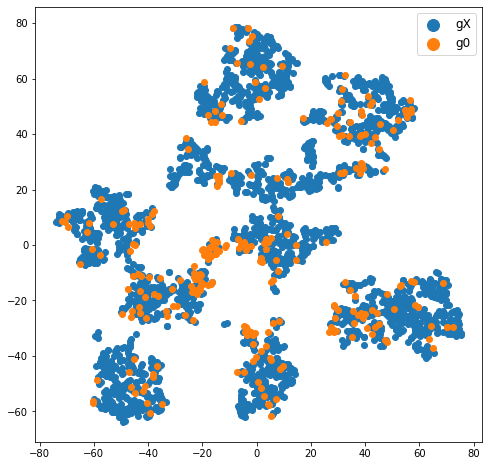

In [26]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
# for lab in graph.ndata['label'].unique():
#   lab = lab.item()
#   indices = graph.ndata['label'].cpu() == lab
#   X = tsne_proj[indices,0]
#   Y = tsne_proj[indices,1]
#   ax.scatter(X, Y, label = lab ,alpha=0.5)

indices = graph.ndata['g0'].cpu() == 0
X = tsne_proj[indices,0]
Y = tsne_proj[indices,1]
ax.scatter(X, Y, label = 'gX' ,alpha=1)

indices = graph.ndata['g0'].cpu() == 1
X = tsne_proj[indices,0]
Y = tsne_proj[indices,1]
ax.scatter(X, Y, label = 'g0' ,alpha=1)

ax.legend(fontsize='large', markerscale=2)
plt.show()

In [27]:
graph.out_degrees(graph.nodes()).shape

torch.Size([2708])

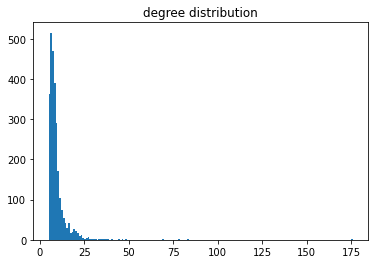

In [32]:
graph = graph.add_self_loop()
hist = graph.out_degrees(graph.nodes()).cpu().numpy()
# hist,bins = np.histogram(hist, bins=10)
plt.hist(hist, bins=range(min(hist), max(hist) + 1, 1)) 
plt.title("degree distribution") 
plt.show()

In [29]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

def get_f1(embeds, graph):
  evaluate_attr = graph.ndata['label']
  split_idx = int(graph.num_nodes() * 0.75)
  lgreg = LogisticRegression(
    random_state=0, 
    class_weight='balanced', 
    max_iter=500).fit(
    embeds[:split_idx].cpu(), evaluate_attr[:split_idx].cpu())
  pred = lgreg.predict(embeds[split_idx:].cpu())

  score = f1_score(evaluate_attr[split_idx:split_idx + pred.shape[0]].cpu(), pred, average='micro')

  print(f'-- micro-f1 when predicting sensitive lab: {score}')
  return score
  

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size != k:
        raise ValueError('Ranking List length < k')    
    return np.sum((2**r - 1) / np.log2(np.arange(2, r.size + 2)))


def ndcg_at_k(r, k):
    sort_r = sorted(r,reverse = True)
    idcg = dcg_at_k(sort_r, k)
    if not idcg:
        print('.', end=' ')
        return 0.
    return dcg_at_k(r, k) / idcg


def eval_link_ndcg(embeds, graph: dgl.DGLGraph):
  accum_ndcg = 0
  node_cnt = 0
  sample_size = int(min(graph.num_nodes() / 25, 75))
  k = int(min(sample_size / 5, 10))
  adj = graph.adj().to_dense()

  for node in graph.nodes():
    node_edges = adj[node]
    positive_nodes = node_edges.nonzero(as_tuple=True)[0]
    split_idx = int(positive_nodes.shape[0] / 10) + 1

    if split_idx == 0 or split_idx > sample_size:
      continue
      
    negative_nodes = np.random.choice(
      (1 - node_edges).nonzero(as_tuple=True)[0], 
      sample_size - split_idx,
      replace=False
    )
    positive_nodes = positive_nodes[:split_idx] # Subset of positive pair
    eval_nodes = np.concatenate((positive_nodes, negative_nodes))
    eval_edges = np.zeros(sample_size)
    eval_edges[:split_idx] = 1

    predicted_edges = np.dot(embeds[node], embeds[eval_nodes].T)
    rank_pred_keys = np.argsort(predicted_edges)[::-1]
    ranked_node_edges = eval_edges[rank_pred_keys]
    ndcg = ndcg_at_k(ranked_node_edges, k)
    accum_ndcg += ndcg

    node_cnt += 1

  score = 1 - (accum_ndcg/node_cnt)
  print(f'-- ndcg of link prediction: {score:.6f}')
  return score

In [30]:
if args.debias_method == 'random':
  embeds = th.rand(embeds.shape)

In [31]:
get_f1(embeds, graph)
# eval_link_ndcg(embeds.cpu(), graph.cpu())

-- micro-f1 when predicting sensitive lab: 0.8227474150664698


/u/nyw6dh/.conda/envs/pytorch_c116/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8227474150664698